In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score

In [2]:
x_train = pd.read_csv(r'C:\Projects_ciência_dados\regression_car_price\data\processed\x_train.csv')
x_test = pd.read_csv(r'C:\Projects_ciência_dados\regression_car_price\data\processed\x_test.csv')
y_train = pd.read_csv(r'C:\Projects_ciência_dados\regression_car_price\data\processed\y_train.csv')
y_test = pd.read_csv(r'C:\Projects_ciência_dados\regression_car_price\data\processed\y_test.csv')

Regressão Linear

In [3]:
regressao_linear = LinearRegression() # É inútil fazer tuning em regressão linear, pois não há parâmetros de aprendizado
regressao_linear.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [4]:
abs(regressao_linear.score(x_train, y_train))

0.9601947084910157

In [5]:
abs(regressao_linear.score(x_test, y_test))

0.7795928902068155

In [6]:
previsao_regressao = regressao_linear.predict(x_test)

In [7]:
mean_absolute_error(previsao_regressao, y_test)

5974.773854834683

Regressão polinomial

###### Grau 2

In [8]:
from sklearn.preprocessing import PolynomialFeatures

In [9]:
y_concatenado = pd.concat([y_train, y_test])

In [10]:
y_concatenado['price'].mean()

np.float64(30340.11298957453)

In [11]:
y_concatenado.median()

price    28000.0
dtype: float64

Árvores

In [12]:
x_train.shape

(2661, 1533)

In [13]:
parametros = {
    'max_depth':[10,20,30, None],
    'min_samples_split':[10, 20, 50,100],
    'min_samples_leaf':[20,50,100,150,200],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

r = RandomizedSearchCV(estimator = DecisionTreeRegressor(), param_distributions = parametros, n_jobs = 4, scoring = 'neg_mean_absolute_error')
r.fit(x_train, y_train)
print(abs(r.best_score_))
print(r.best_params_)

7471.014307579455
{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 20, 'criterion': 'absolute_error'}


In [14]:
tree = DecisionTreeRegressor()

Random Forest

In [15]:
parametros = {
    'max_depth':[10, 20, 30, 50, 100, None],
    'min_samples_split':[10, 20, 50, 100],
    'min_samples_leaf':[20, 50, 100, 150, 200],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_features':['sqrt', 'log2'],
    'n_estimators':[60, 80, 100, 200, 300]
}

r = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = parametros, n_jobs = 4, scoring = 'neg_mean_absolute_error')
r.fit(x_train, y_train)
print(abs(r.best_score_))
print(r.best_params_)

c:\Projects_ciência_dados\regression_car_price\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


13076.496944636585
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'squared_error'}


SVM

In [ ]:
parametros = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto'],
    'tol':[0.0001, 0.001, 0.01],
    'C':[0.25, 0.5, 1, 2, 5]
}

rsvm = RandomizedSearchCV(estimator = SVR(), param_distributions = parametros, n_jobs = 4, scoring = 'neg_mean_absolute_error')
rsvm.fit(x_train, y_train)
print(rsvm.best_params_)
print(abs(rsvm.best_score_))

XGBoost

In [ ]:
parametros_xgb = {
    'n_estimators': [80, 100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 10],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_beta': [0, 0.01, 0.1, 1] if False else [0, 0.01, 0.1, 1],  
}

rx = RandomizedSearchCV(estimator = XGBRegressor(), param_distributions = parametros_xgb, n_jobs = 4, scoring = 'neg_mean_absolute_error')
rx.fit(x_train, y_train)
print(rx.best_params_)
print(abs(rx.best_score_))


c:\Projects_ciência_dados\regression_car_price\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:31:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "reg_beta" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'subsample': 0.8, 'reg_beta': 0.1, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 1.0}
5401.1896484375


Validação cruzada robusta

In [ ]:
regressao_resultados = []
arvore_resultados = []
random_forest_resultados = []
svm_resultados = []
xgboost_resultados = []
mlp_resultados = []

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    
    regression = LinearRegression()
    scores = cross_val_score(regression, x_train, y_train, cv=kfold, n_jobs=4,scoring='neg_mean_absolute_error')
    regressao_resultados.append(abs(scores.mean()))
    
    arvore = DecisionTreeRegressor(min_samples_split= 50, min_samples_leaf= 20, max_depth= 30, criterion= 'friedman_mse')
    scores = cross_val_score(arvore, x_train, y_train, cv=kfold, n_jobs=4, scoring='neg_mean_absolute_error')
    arvore_resultados.append(abs(scores.mean()))
    
    random_forest = RandomForestRegressor(n_estimators= 80, min_samples_split= 20, min_samples_leaf= 20, max_features= 'sqrt', max_depth= 10, criterion= 'squared_error')
    scores = cross_val_score(random_forest, x_train, y_train, cv=kfold, n_jobs=4, scoring='neg_mean_absolute_error')
    random_forest_resultados.append(abs(scores.mean()))
    
    SVM = SVR(tol= 0.001, kernel= 'linear', gamma= 'scale', C= 0.5)
    scores = cross_val_score(SVM, x_train, y_train, cv=kfold, n_jobs=4, scoring='neg_mean_absolute_error')
    svm_resultados.append(abs(scores.mean()))
    
    xgboost = XGBRegressor(subsample= 0.7, reg_beta= 0.01, reg_alpha= 1, n_estimators= 400, max_depth= 5, learning_rate= 0.05, gamma= 0, colsample_bytree= 0.6)
    scores = cross_val_score(xgboost, x_train, y_train, cv=kfold, n_jobs=4, scoring='neg_mean_absolute_error')
    xgboost_resultados.append(abs(scores.mean()))
    

Simplificar mlp e colocar em um arquivo separado

In [ ]:
parametros_mlp = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (64,32)],
    'activation': ['relu'], 
    'solver': ['adam'], 
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [400, 600],
    'batch_size': ['auto', 32, 64]
}

rmlp = RandomizedSearchCV(estimator = MLPRegressor(), param_distributions = parametros_mlp, n_jobs = 4, scoring = 'neg_mean_absolute_error')
rmlp.fit(x_train, y_train)
print(rmlp.best_params_)
print(abs(rmlp.best_score_))


In [ ]:
mlp_resultados = []

for i in range(30):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    mlp = MLPRegressor(solver= 'adam', max_iter= 400, learning_rate_init= 0.001, learning_rate= 'adaptive', hidden_layer_sizes= (64, 32), batch_size= 64, alpha= 0.001, activation= 'relu')
    scores = cross_val_score(mlp, x_train, y_train, cv=kfold, verbose=True)
    mlp_resultados.append(scores.mean())
    

c:\Projects_ciência_dados\regression_car_price\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Projects_ciência_dados\regression_car_price\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Projects_ciência_dados\regression_car_price\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1771: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Projects_ciência_dados\regression_car_price\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interr

In [ ]:
resultados = pd.DataFrame({
    'regression':regressao_resultados,
    'arvore':arvore_resultados,
    'random_forest':random_forest_resultados,
    'svm':svm_resultados,
    'xgboost':xgboost_resultados
})

In [ ]:
resultados

,regression,arvore,random_forest,svm,xgboost
0,6132.884648,7372.226434,13208.855483,13423.714349,5293.553857
1,6176.720075,7315.520649,13219.604807,13420.411689,5319.033398
2,6202.709713,7460.997051,13197.829474,13418.214442,5310.966895
3,6214.339962,7339.318509,13202.900687,13419.262521,5273.968896
4,6214.282045,7390.870646,13230.706886,13421.983492,5277.123975
5,6158.957692,7398.898080,13305.057911,13416.426704,5321.405127
6,6277.587985,7369.525915,13190.528007,13419.086597,5292.384375
7,6164.396077,7337.805054,13223.001999,13420.512122,5313.142773
8,6181.765561,7283.916512,13340.942834,13418.742076,5274.944336
9,6194.906428,7396.734892,13168.912334,13422.538917,5338.440723


In [ ]:
resultados.describe()

,regression,arvore,random_forest,svm,xgboost
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,6190.789741,7378.234469,13218.732989,13420.517932,5308.976388
std,30.922798,53.482205,59.356734,3.658840,26.228263
min,6132.884648,7280.928066,13132.754449,13414.545696,5261.239551
25%,6174.858868,7343.395968,13172.086435,13418.276411,5293.398584
50%,6191.131321,7370.876174,13207.274603,13419.923317,5302.042627
75%,6208.548578,7409.408165,13242.270436,13422.400061,5322.109058
max,6277.587985,7508.618658,13340.942834,13431.234975,5383.934717


Coeficiente de variação

In [ ]:
(resultados.std() / resultados.mean()) * 100

regression       0.499497
arvore           0.724865
random_forest    0.449035
svm              0.027263
xgboost          0.494036
dtype: float64

Teste de normalidade

In [ ]:
from scipy.stats import shapiro

In [ ]:
shapiro(regressao_resultados), shapiro(arvore_resultados), shapiro(random_forest_resultados), shapiro(svm_resultados), shapiro(xgboost_resultados)

(ShapiroResult(statistic=np.float64(0.9766390176720695), pvalue=np.float64(0.7309052771359278)),
 ShapiroResult(statistic=np.float64(0.9808725716710956), pvalue=np.float64(0.8482554433553022)),
 ShapiroResult(statistic=np.float64(0.9183834299784207), pvalue=np.float64(0.024357092555843292)),
 ShapiroResult(statistic=np.float64(0.9533081098952034), pvalue=np.float64(0.20715128877256617)),
 ShapiroResult(statistic=np.float64(0.9559980681796625), pvalue=np.float64(0.2439497279690926)))

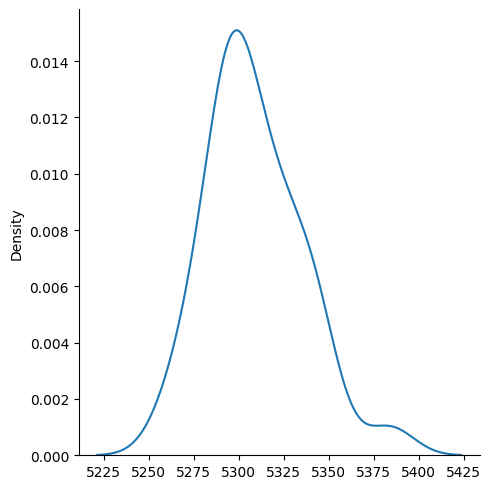

In [ ]:
import seaborn as sns
sns.displot(xgboost_resultados, kind='kde')

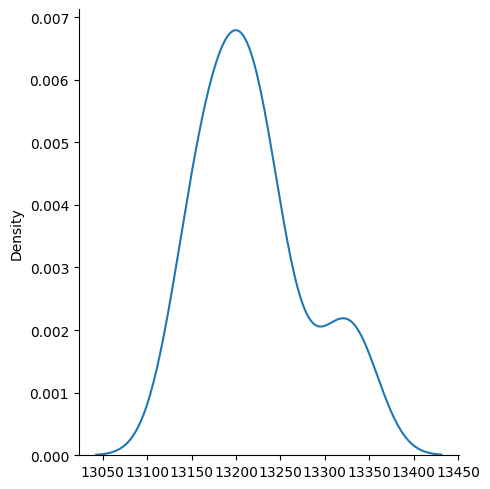

In [ ]:
sns.displot(random_forest_resultados, kind='kde')

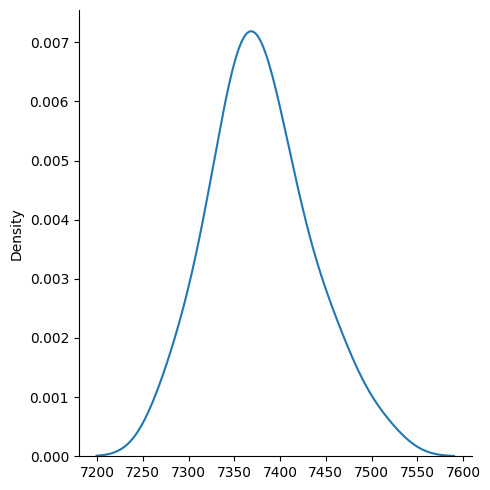

In [ ]:
sns.displot(arvore_resultados, kind='kde')

Anova

In [ ]:
from scipy.stats import f_oneway

In [ ]:
_, p_value = f_oneway(regressao_resultados, arvore_resultados, random_forest_resultados, svm_resultados, xgboost_resultados)

In [ ]:
if p_value < 0.05:
    print('H0 rejeitada. Existe diferença significativa entre os resultados')
else:
    print('Não existe diferença significatica entre os resultados')

H0 rejeitada. Existe diferença significativa entre os resultados


In [ ]:
p_value

np.float64(1.8718286044880283e-281)

Tukey

In [ ]:
algoritmos_nomes = ['xgboost', 'random_forest', 'svm', 'arvore', 'regressao_linear']

In [ ]:
algoritmos_resultados = [xgboost_resultados, random_forest_resultados, svm_resultados, arvore_resultados, regressao_resultados]

In [ ]:
resultados_algoritmos = pd.DataFrame({
    'MAE':np.concatenate(algoritmos_resultados),
    'algoritmos':np.repeat(algoritmos_nomes, [len(arr) for arr in algoritmos_resultados])
})

In [ ]:
from statsmodels.stats.multicomp import MultiComparison

In [ ]:
compara_algoritmos = MultiComparison(resultados_algoritmos['MAE'], resultados_algoritmos['algoritmos'])

In [ ]:
teste_estatistico = compara_algoritmos.tukeyhsd()
print(teste_estatistico)